In [50]:
import pandas as pd
import numpy as np
import math
from scipy.stats import describe, randint
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import scipy.sparse

sns.set()

# Methods for exporting tables and images to latex
def saveimg(filename, fig):
    file_path = os.path.join(os.getcwd(), 'images')
    os.makedirs(file_path, exist_ok=True)
    fig.savefig(os.path.join(file_path, filename))
    
def savetable(filename, df):
    file_path = os.path.join(os.getcwd(), 'tables')
    os.makedirs(file_path, exist_ok=True)
    pd.DataFrame(df).to_latex(os.path.join(file_path, filename),escape = False, index = False)

# 3.

In [261]:
def random_neighbour(points):

    # Getting dimensions of points
    dimension = np.shape(points)
    
    # Generate if going up or down, do this for all points
    up_or_down = 2*np.random.randint(2, size=dimension[0]) - 1
    
    # Generate which diretion to go in for all points
    direction = np.random.randint(dimension[1], size=dimension[0])
    
    # Create new matrix, create a binary matrix of the direction
    indptr = range(len(direction)+1)
    data = np.ones(len(direction))
    points_to_change = scipy.sparse.csr_matrix((data, direction, indptr)).toarray()
    
    # Add the binary matrix multiplied by direction to the old points
    new_points = points + (points_to_change.T*up_or_down).T
    
    return new_points

def is_self_avoiding(random_walk):
    return int(len(np.unique(random_walk, axis=0)) == len(random_walk))

def generate_weights(random_walks, weights):
    
    # Get indexes where weights is different from zero
    indexes = np.nonzero(weights)[0]
    
    # Create new weights
    new_weights = np.zeros(len(weights))
    
    # Start by swapping axis i and k so it is possible to iterate over all random walks
    random_walks_list = np.swapaxes(random_walks, 0, 1)
    
    # Looping over wieghts different from zero
    for index in indexes:
        new_weights[index] = is_self_avoiding(random_walks_list[index])
        
    return new_weights      

def init_walk (d, k, N):
    
    # The random_walk array has the following structure compared 
    # to the lecture notes random_walk[k][i][d], where:
    # k = step number k
    # i = simulation number
    # d = dimension 
    
    random_walks = []
    weights = [[1] * N]
    
    random_walks.append(np.zeros((N, d)))
    
    for step in range(k):
        step_all = random_neighbour(random_walks[step])
        random_walks.append(step_all)
        weights.append(generate_weights(random_walks, weights[step]))
        print(step)
        
    return random_walks, weights

In [258]:
walks, weights = init_walk(2,50,10**5)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [259]:
prob = []
for row in weights:
    prob.append(np.mean(row))

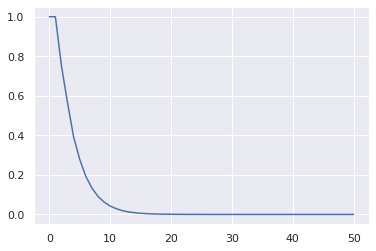

In [260]:
plt.plot(range(len(weights)), prob)